<a href="https://colab.research.google.com/github/bholeneha/Text_Classification/blob/neha/S3_LDA_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing warning to ignore it. 
import warnings; warnings.simplefilter('ignore')

In [2]:
# Importing Spark 
import os
spark_version = 'spark-3.1.1'
os.environ['SPARK_VERSION']=spark_version
 
# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark
 
# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"
 
# Start a SparkSession
import findspark
findspark.init()
 
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("LDA").getOrCreate()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graph

In [3]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url = "https://nehabhole-bucket.s3.us-east-2.amazonaws.com/emails.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("emails.csv"), header=True)

In [4]:
# Check data
df.show()

+---------+--------------------+-----+
|file_name|                text|class|
+---------+--------------------+-----+
|14147.txt| Archive name  ri...|Crime|
|14831.txt|Approved  news an...|Crime|
|14832.txt|Approved  news an...|Crime|
|14982.txt|Message ID   1ppv...|Crime|
|14983.txt|    Some sick par...|Crime|
|14984.txt| There are many U...|Crime|
|14985.txt|  From  res colne...|Crime|
|14986.txt|Message ID   WARL...|Crime|
|14987.txt| neuhaus vier inf...|Crime|
|14988.txt|   This thread br...|Crime|
|14989.txt| With regard to y...|Crime|
|14990.txt| In article  2bb2...|Crime|
|14991.txt|Message ID   1pqu...|Crime|
|14992.txt| In article  1ppg...|Crime|
|14993.txt| strnlght netcom ...|Crime|
|14994.txt| Markowitz DOCKMA...|Crime|
|14995.txt| cuffell spot Col...|Crime|
|14996.txt|   This actually ...|Crime|
|14997.txt| Michael Levin wr...|Crime|
|14998.txt|   cme ellisun sw...|Crime|
+---------+--------------------+-----+
only showing top 20 rows



In [5]:
# Import Pandas and transform dataset to a pandas dataframe
import pandas as pd
data_df = df.toPandas()

In [6]:
# Check Dataframe
data_df.head()

,file_name,text,class
0,14147.txt,Archive name ripem faq Last update Sun 7 M...,Crime
1,14831.txt,Approved news answers request MIT EDU Content...,Crime
2,14832.txt,Approved news answers request MIT EDU Content...,Crime
3,14982.txt,Message ID 1ppvai l79 bilbo suite com Reply...,Crime
4,14983.txt,Some sick part of me really liked that phr...,Crime


In [7]:
# Check the shape of data to check for missing rows
data_df.shape

(9154, 3)

In [9]:
# Check for null values and datatypes
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9154 entries, 0 to 9153
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  9154 non-null   object
 1   text       9123 non-null   object
 2   class      9154 non-null   object
dtypes: object(3)
memory usage: 214.7+ KB


In [10]:
# Check the columns
data_df.columns

Index(['file_name', 'text', 'class'], dtype='object')

In [11]:
# Drop rows with null values
data_df.dropna()

,file_name,text,class
0,14147.txt,Archive name ripem faq Last update Sun 7 M...,Crime
1,14831.txt,Approved news answers request MIT EDU Content...,Crime
2,14832.txt,Approved news answers request MIT EDU Content...,Crime
3,14982.txt,Message ID 1ppvai l79 bilbo suite com Reply...,Crime
4,14983.txt,Some sick part of me really liked that phr...,Crime
...,...,...,...
9149,62615.txt,Distribution world Message ID cshotton 1805...,Science
9150,62616.txt,Jeffrey L Cook sez This object would not ...,Science
9151,62708.txt,Message ID 1tdqmvINN3q2 hp col col hp com R...,Science
9152,62709.txt,Message ID 1t6dd1 11v network ucsd edu Refe...,Science


In [14]:
# Change datatype of the text column to string
data_df['text'] = data_df['text'].astype(str)

In [8]:
# Import dependencies for NLP
import numpy as np 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import regex
from nltk.corpus import stopwords 
from nltk.tokenize import WordPunctTokenizer
from string import punctuation
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [12]:
# Create a function to create a wordcloud 
def make_wordcloud(words,title):
    cloud = WordCloud(width=1920, height=1080,max_font_size=200, max_words=300, background_color="white").generate(words)
    plt.figure(figsize=(20,20))
    plt.imshow(cloud, interpolation="gaussian")
    plt.axis("off") 
    plt.title(title, fontsize=60)
    plt.show()

In [13]:
# Process the text using NLP methods 
wordnet_lemmatizer = WordNetLemmatizer()

stop = stopwords.words('english')

for punct in punctuation:
    stop.append(punct)

# Create a function to filter text
def filter_text(text, stop_words):
    word_tokens = WordPunctTokenizer().tokenize(text.lower())
    filtered_text = [regex.sub(u'\p{^Latin}', u'', w) for w in word_tokens if w.isalpha() and len(w) > 3]
    filtered_text = [wordnet_lemmatizer.lemmatize(w, pos="v") for w in filtered_text if not w in stop_words] 
    return " ".join(filtered_text)

In [16]:
# Create a filtered_text column and add filtered text data
data_df["filtered_text"] = data_df.text.apply(lambda x : filter_text(x, stop)) 
data_df.head()

,file_name,text,class,filtered_text
0,14147.txt,Archive name ripem faq Last update Sun 7 M...,Crime,archive name ripem last update post still rath...
1,14831.txt,Approved news answers request MIT EDU Content...,Crime,approve news answer request content type text ...
2,14832.txt,Approved news answers request MIT EDU Content...,Crime,approve news answer request content type text ...
3,14982.txt,Message ID 1ppvai l79 bilbo suite com Reply...,Crime,message bilbo suite reply miller suite nntp po...
4,14983.txt,Some sick part of me really liked that phr...,Crime,sick part really like phrase actually merely t...


In [17]:
# Loop over filtered text in each row and create a word list
word_list = []
for text in data_df["filtered_text"]:
    temp = text.split(" ")
    word_list.append(temp)
 
# Print the word list    
print(word_list)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [18]:
# Import gensim and relevant dependencies
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
# Create Dictionary 
id2word = corpora.Dictionary(word_list)

# Create Corpus
texts = word_list

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



#**TRAINING LDA MODEL**

In [21]:
#Import PPrint 
from pprint import pprint
# number of topics
num_topics = 4
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.008*"write" + 0.006*"would" + 0.005*"article" + 0.004*"space" + '
  '0.004*"know" + 0.004*"like" + 0.004*"time" + 0.004*"people" + 0.004*"also" '
  '+ 0.004*"orbit"'),
 (1,
  '0.008*"would" + 0.006*"write" + 0.005*"post" + 0.005*"article" + '
  '0.005*"make" + 0.005*"like" + 0.004*"people" + 0.004*"think" + '
  '0.004*"space" + 0.004*"nntp"'),
 (2,
  '0.007*"write" + 0.006*"would" + 0.005*"article" + 0.005*"know" + '
  '0.004*"make" + 0.004*"like" + 0.004*"post" + 0.004*"people" + 0.004*"space" '
  '+ 0.004*"think"'),
 (3,
  '0.006*"space" + 0.006*"would" + 0.006*"write" + 0.005*"article" + '
  '0.004*"know" + 0.004*"nasa" + 0.004*"use" + 0.004*"time" + 0.004*"make" + '
  '0.003*"also"')]


In [22]:
# Install pyLDAvis
!pip install pyLDAvis==2.1.2

In [23]:
# Create a visualization for LDA Model using pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.023178 -0.003751       1        1  47.408586
1     -0.000616 -0.020532       2        1  22.188494
0     -0.025808  0.000156       3        1  16.949961
3      0.003247  0.024127       4        1  13.452958, topic_info=        Term         Freq        Total Category  logprob  loglift
10960  orbit  1625.000000  1625.000000  Default  30.0000  30.0000
1231   space  5910.000000  5910.000000  Default  29.0000  29.0000
616    would  9034.000000  9034.000000  Default  28.0000  28.0000
445    write  9185.000000  9185.000000  Default  27.0000  27.0000
3711    nasa  3533.000000  3533.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
1650      go   411.742272  3182.381898   Topic4  -6.1071  -0.0390
302     post   493.760823  5342.730765   Topic4  -5.9254  -0.3755
486    could   411.204199  3961.290486   Topic4  -6.1084  -0.2593
503     even   364.623418  3260.641293   Topic4  -6.2286  -0.1848
146     find   361.355638  3130.335334   Topic4  -6.2376  -0.1531

[387 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
2          1  0.344153   access
2          2  0.381277   access
2          3  0.125922   access
2          4  0.148498   access
16181      1  0.180197  accrete
...      ...       ...      ...
1637       4  0.092940     year
1093       1  0.476022    years
1093       2  0.183264    years
1093       3  0.206462    years
1093       4  0.134548    years

[936 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

# Useful insights into the data set by constructing wordclouds and find term frequencies in each topic (Topic=4)

In [25]:
# Import WordCloud 
from wordcloud import WordCloud

###CRIME

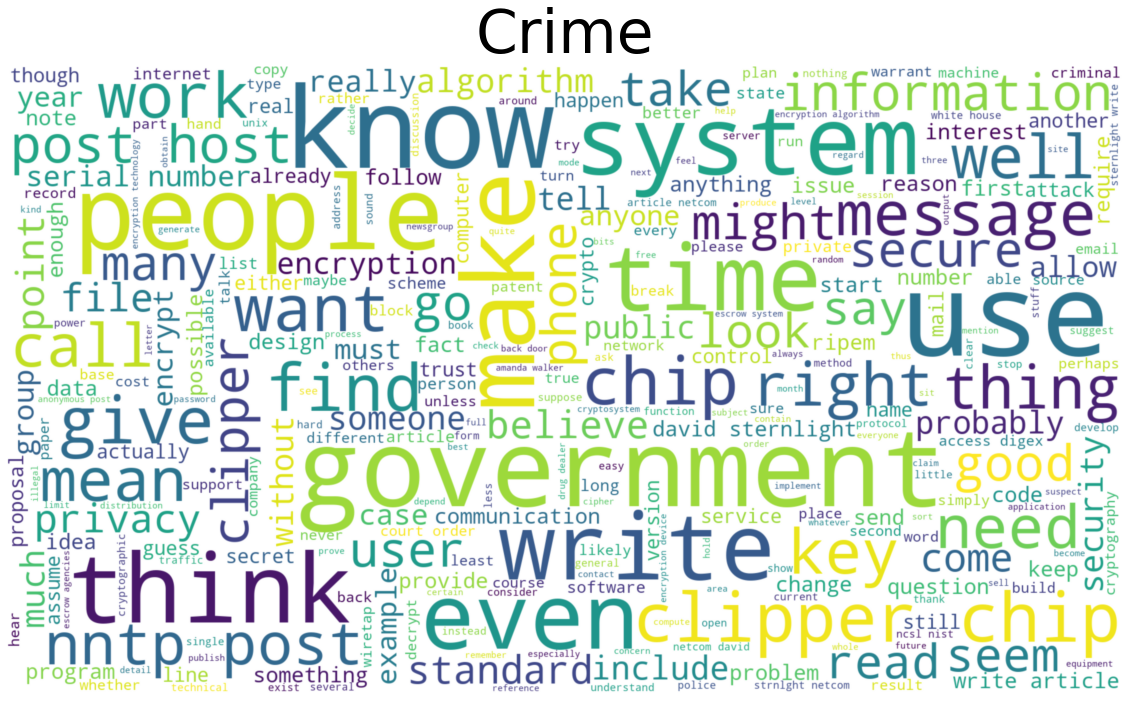

In [26]:
# Create a wordcloud for Crime class
all_text = " ".join(data_df[data_df["class"] =="Crime"].filtered_text) 
make_wordcloud(all_text, "Crime")

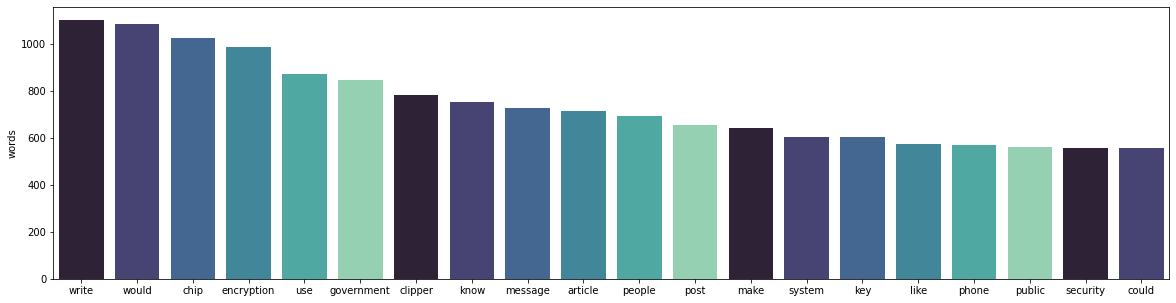

In [27]:
# Create a graph for Crime class
count = pd.DataFrame(all_text.split(), columns = ['words'])
top_10 = count[count['words'].isin(list(count.words.value_counts()[:20].index[:20]))]
plt.figure(figsize=(20,5))
sns.barplot(x = top_10.words.value_counts().index,
            y = top_10.words.value_counts(), palette = sns.color_palette("mako"))

###POLITICS

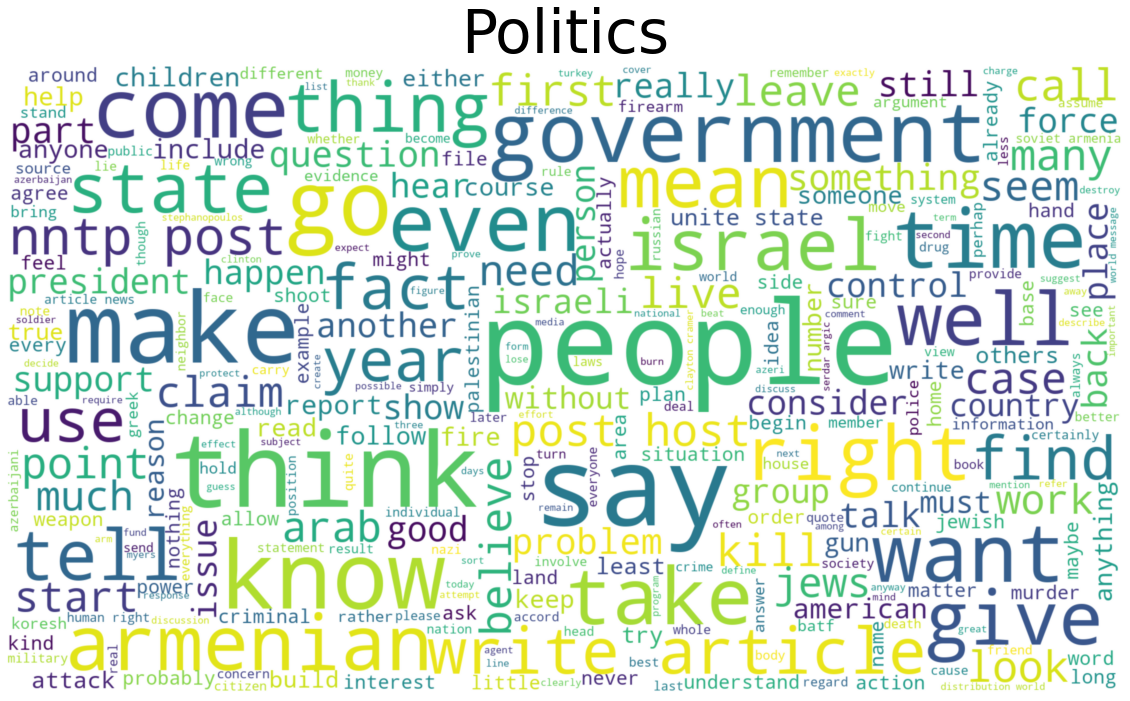

In [28]:
# Create a wordcloud for Politics class
all_text = " ".join(data_df[data_df["class"] == "Politics"].filtered_text) 
make_wordcloud(all_text, "Politics")

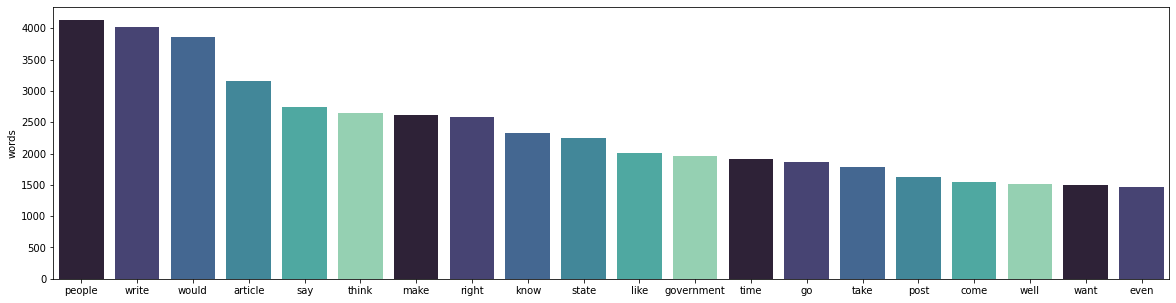

In [29]:
# Create a graph for Politics class
count = pd.DataFrame(all_text.split(), columns = ['words'])
top_10 = count[count['words'].isin(list(count.words.value_counts()[:20].index[:20]))]
plt.figure(figsize=(20,5))
sns.barplot(x = top_10.words.value_counts().index,
            y = top_10.words.value_counts(), palette = sns.color_palette("mako"))

### SCIENCE

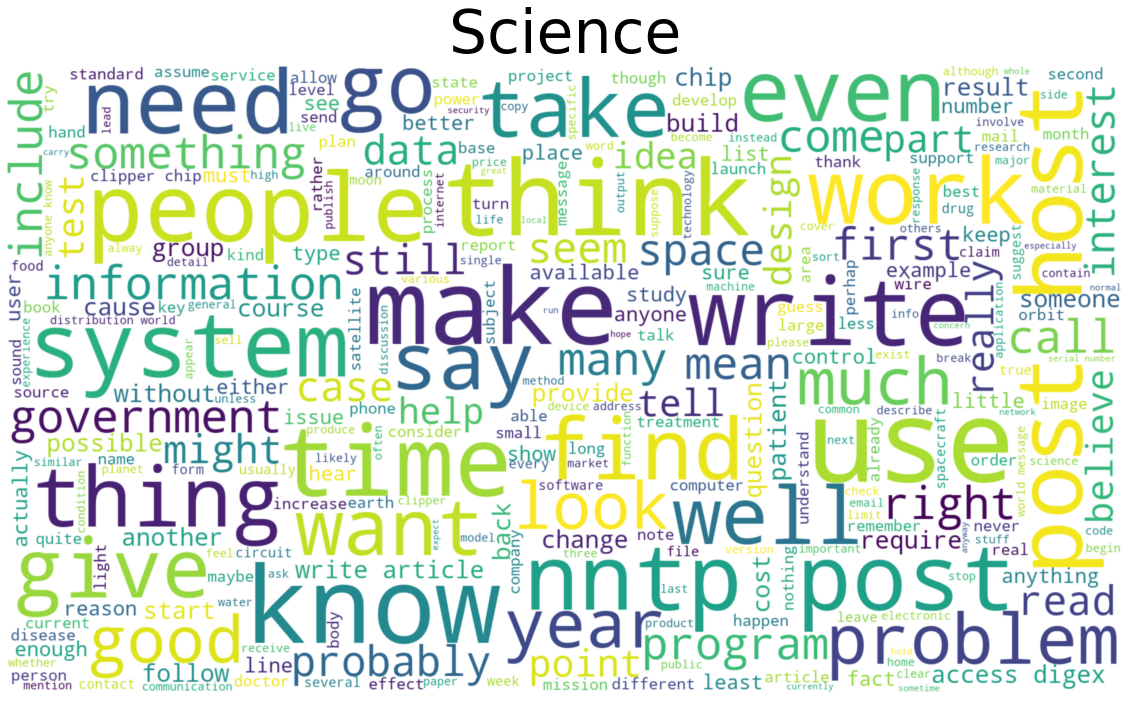

In [30]:
# Create a wordcloud for Science class
all_text = " ".join(data_df[data_df["class"] == "Science"].filtered_text) 
make_wordcloud(all_text, "Science")

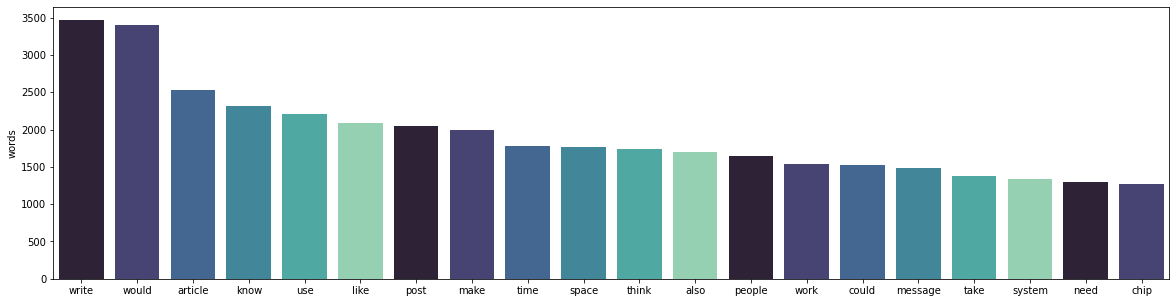

In [31]:
# Create a graph for Science class
count = pd.DataFrame(all_text.split(), columns = ['words'])
top_10 = count[count['words'].isin(list(count.words.value_counts()[:20].index[:20]))]
plt.figure(figsize=(20,5))
sns.barplot(x = top_10.words.value_counts().index,
            y = top_10.words.value_counts(), palette = sns.color_palette("mako"))

### ENTERTAINMENT

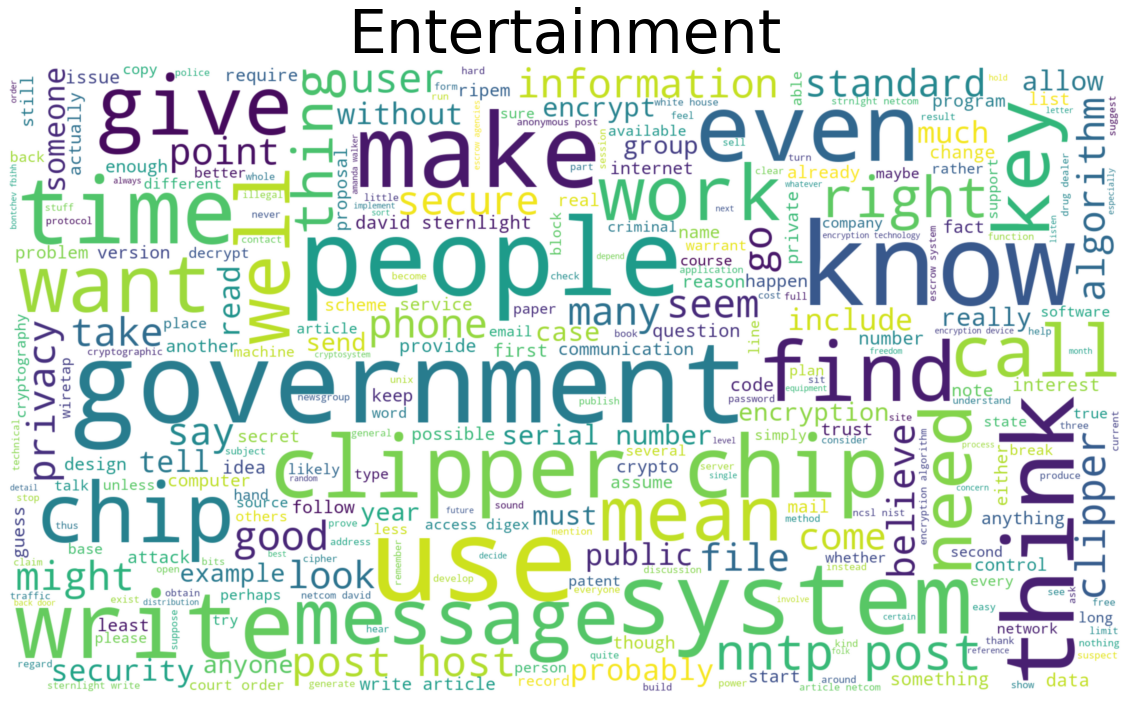

In [32]:
# Create a wordcloud for Entertainment class
all_text = " ".join(data_df[data_df["class"] == "Entertainment"].filtered_text) 
make_wordcloud(all_text, "Entertainment")

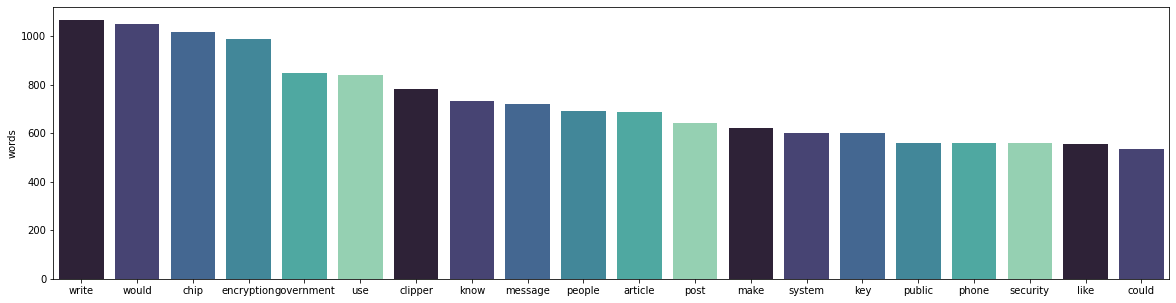

In [33]:
# Create a graph for Entertainment class
count = pd.DataFrame(all_text.split(), columns = ['words'])
top_10 = count[count['words'].isin(list(count.words.value_counts()[:20].index[:20]))]
plt.figure(figsize=(20,5))
sns.barplot(x = top_10.words.value_counts().index,
            y = top_10.words.value_counts(), palette = sns.color_palette("mako"))

# SAVE THE MODEL USING PICKLE

In [35]:
# Connect Google Drive to Colab Notebooks
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [36]:
#Import Pickle
import pickle

# Save the LDA model 
file = open('/content/gdrive/My Drive/Colab Notebooks/data/model/lda_model', 'wb')
pickle.dump(lda_model, file)
